# Web App Event Logs - Enhanced Analysis for Final Report

This notebook analyzes web app event logs stored as JSON files in `reports/monitor-logs/YYYY/MM/DD/` structure.

## Contents
1. Data Loading and Preparation
2. 12 Key Visualizations for Final Report
3. Additional Analysis

Each JSON file contains:
```json
{
  "sessionId": "session_1754052978056_4i3x2c3bc1g3g4j2",
  "timestamp": "20250801T125618127Z",
  "eventType": "sessionStart",
  "payload": { ... },
  "server_context": { ... }
}
```

## 0. Setup and configuration

In [1]:
import glob
import json
import os
from datetime import datetime, timedelta
from pathlib import Path

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.patches import Rectangle

# Set style for better visualizations
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 6)
plt.rcParams["font.size"] = 10

# Set up paths
log_base_path = Path("monitor-logs")
print(f"Base log path: {log_base_path}")
print(f"Path exists: {log_base_path.exists()}")

Base log path: monitor-logs
Path exists: True


## 1. Data Loading and Preparation

In [2]:
def load_all_log_files(base_path="monitor-logs", min_date="20250705"):
    """
    Load all JSON files from the log directory structure.

    Handles the recursive YYYY/MM/DD/ folder structure.
    Each JSON file contains: sessionId, timestamp, eventType, payload, server_context.

    Args:
        base_path: Path to monitor-logs directory
        min_date: Only load files from this date onwards (format: YYYYMMDD, e.g., '20250705')

    """
    all_events = []
    file_count = 0
    error_count = 0
    skipped_count = 0

    # Use glob to find all JSON files recursively
    json_pattern = os.path.join(base_path, "**/*.json")
    json_files = glob.glob(json_pattern, recursive=True)

    print(f"Found {len(json_files)} JSON files total\n")
    if min_date:
        print(f"Filtering for files from {min_date} onwards (July 5, 2025)\n")

    # Load each file
    for file_path in json_files:
        # Filter by date if min_date is specified
        if min_date:
            # Extract date from path: monitor-logs/YYYY/MM/DD/...
            path_parts = file_path.split(os.sep)
            if len(path_parts) >= 4:
                try:
                    year = path_parts[-4]
                    month = path_parts[-3]
                    day = path_parts[-2]
                    file_date = f"{year}{month}{day}"
                    if file_date < min_date:
                        skipped_count += 1
                        continue
                except (ValueError, IndexError):
                    pass

        try:
            with open(file_path) as f:
                event_data = json.load(f)

            # Validate required fields
            if all(
                key in event_data for key in ["sessionId", "timestamp", "eventType"]
            ):
                all_events.append(event_data)
                file_count += 1
            else:
                error_count += 1

        except (OSError, json.JSONDecodeError):
            error_count += 1

    print(f"Successfully loaded: {file_count} files")
    print(f"Skipped (before cutoff): {skipped_count} files")
    if error_count > 0:
        print(f"Errors encountered: {error_count} files\n")

    return all_events


# Load all events (from July 5, 2025 onwards)
all_events = load_all_log_files(min_date="20250705")

print(f"\nTotal events loaded: {len(all_events)}")

# Create DataFrame immediately
events_df = pd.DataFrame(all_events)

# Parse timestamp to datetime
events_df["timestamp"] = pd.to_datetime(
    events_df["timestamp"], format="%Y%m%dT%H%M%S%fZ"
)

# Explode server_context into separate columns
if "server_context" in events_df.columns:
    server_context_df = pd.json_normalize(events_df["server_context"].tolist())
    # Prefix columns to avoid conflicts
    server_context_df.columns = ["server_" + col for col in server_context_df.columns]
    events_df = pd.concat([events_df, server_context_df], axis=1)
    print(f"\nExpanded {len(server_context_df.columns)} server_context fields")

# Add derived columns for analysis
events_df["date"] = events_df["timestamp"].dt.date
events_df["hour"] = events_df["timestamp"].dt.hour
events_df["day_of_week"] = events_df["timestamp"].dt.day_name()

print(f"\nDataFrame created with shape: {events_df.shape}")
print(f"Columns: {events_df.columns.tolist()}")

Found 3965 JSON files total

Filtering for files from 20250705 onwards (July 5, 2025)

Successfully loaded: 1849 files
Skipped (before cutoff): 2116 files

Total events loaded: 1849

Expanded 4 server_context fields

DataFrame created with shape: (1849, 12)
Columns: ['sessionId', 'timestamp', 'eventType', 'payload', 'server_context', 'server_client_ip', 'server_forwarded_for', 'server_received_at', 'server_server_version', 'date', 'hour', 'day_of_week']


...

### Data Augmentation - Generation of supplementary columns 

In [3]:
# Placeholder, to be filled so that visualizations and analyses below use REAL not mock data.

## 2. Exploratory Data Description

### Summary statistics

In [4]:
print("\n" + "=" * 60)
print("SUMMARY STATISTICS")
print("=" * 60)
print(f"Total events:          {len(events_df):,}")
print(f"Total unique sessions: {events_df['sessionId'].nunique():,}")
print(
    f"Avg events per session: {len(events_df) / events_df['sessionId'].nunique():.2f}"
)
print(f"\nDate range: {events_df['timestamp'].min()} to {events_df['timestamp'].max()}")

# Show server context fields if available
server_cols = [col for col in events_df.columns if col.startswith("server_")]
if server_cols:
    print(
        f"\nServer context fields: {', '.join([col.replace('server_', '') for col in server_cols])}"
    )


SUMMARY STATISTICS
Total events:          1,849
Total unique sessions: 259
Avg events per session: 7.14

Date range: 2025-07-05 09:28:26.798000 to 2025-10-09 09:33:21.109000

Server context fields: context, client_ip, forwarded_for, received_at, version


### Events by Type

Breakdown of event types in the dataset.

In [5]:
print("\n" + "=" * 60)
print("EVENTS BY TYPE")
print("=" * 60)

event_type_df = events_df["eventType"].value_counts().reset_index()
event_type_df.columns = ["eventType", "count"]
event_type_df["percentage"] = (
    event_type_df["count"] / event_type_df["count"].sum() * 100
).round(2)

print(event_type_df.to_string(index=False))


EVENTS BY TYPE
       eventType  count  percentage
visibilityChange   1043       56.41
    sessionStart    259       14.01
         request    188       10.17
         article    129        6.98
        response    104        5.62
       userInput    103        5.57
        feedback     19        1.03
     userProfile      4        0.22


### Sample Events

Peek at sample events from each type to understand data structure.

In [6]:
print("\n" + "=" * 60)
print("SAMPLE EVENTS BY TYPE")
print("=" * 60)

for event_type in sorted(events_df["eventType"].unique()):
    sample = events_df[events_df["eventType"] == event_type].iloc[0].to_dict()
    print(f"\n{event_type.upper()}:")
    print(json.dumps(sample, indent=2, default=str)[:600])
    print("-" * 60)


SAMPLE EVENTS BY TYPE

ARTICLE:
{
  "sessionId": "session_1752137723364_6y2xy3v6v1n72261j",
  "timestamp": "2025-07-10 09:31:39.577000",
  "eventType": "article",
  "payload": {
    "queryId": "query_1752139891296_usat982",
    "htmlContent": "<h2>Table des centrales \u00e9lectriques en tunisie ?</h2>\n            <div class=\"attribution\">Generated by Cirdi on Thursday, July 10, 2025</div>\n            <div class=\"generation-stats\"><span> Tokens: 0 in, 1,088 out. LLM cost: 0.87 cent. Self hosting cost: 0.20 cent (H100 VPS hourly rate for 2.37s.). </span></div>\n            <div class=\"settings-stats\">Retrieval en mode 
------------------------------------------------------------

FEEDBACK:
{
  "sessionId": "session_1752134107494_f2a4x3f6ij1a6v1k",
  "timestamp": "2025-07-10 09:08:22.606000",
  "eventType": "feedback",
  "payload": {
    "type": "up",
    "comment": ""
  },
  "server_context": {
    "client_ip": "193.51.112.3",
    "forwarded_for": "193.51.112.3",
    "received_a

### DataFrame Overview

Display key information about the DataFrame structure.

In [7]:
print(f"\nDataFrame shape: {events_df.shape}")
print(f"\nColumns: {events_df.columns.tolist()}")
print("\nData types:")
print(events_df.dtypes)
print("\nFirst few rows:")
display_cols = ["sessionId", "timestamp", "eventType"]
# Add server context columns if available
server_cols = [col for col in events_df.columns if col.startswith("server_")]
if server_cols:
    display_cols.extend(server_cols[:3])  # Show first 3 server fields
print(events_df[display_cols].head(10))


DataFrame shape: (1849, 12)

Columns: ['sessionId', 'timestamp', 'eventType', 'payload', 'server_context', 'server_client_ip', 'server_forwarded_for', 'server_received_at', 'server_server_version', 'date', 'hour', 'day_of_week']

Data types:
sessionId                        object
timestamp                datetime64[ns]
eventType                        object
payload                          object
server_context                   object
server_client_ip                 object
server_forwarded_for             object
server_received_at               object
server_server_version            object
date                             object
hour                              int32
day_of_week                      object
dtype: object

First few rows:
                                  sessionId               timestamp  \
0  session_1752134176025_3x2b5j1e5n2v4l622p 2025-07-10 07:56:16.048   
1  session_1752134176025_3x2b5j1e5n2v4l622p 2025-07-10 07:56:23.775   
2  session_1752134176025_3x2b5j1e

### Payload Structure Analysis

Analyze the structure of payload fields for each event type.

In [8]:
print("\n" + "=" * 60)
print("PAYLOAD STRUCTURE BY EVENT TYPE")
print("=" * 60)

# Extract payload keys for each event type
payload_structure = []
for event_type in sorted(events_df["eventType"].unique()):
    type_df = events_df[events_df["eventType"] == event_type]
    all_keys = set()
    for payload in type_df["payload"]:
        if isinstance(payload, dict):
            all_keys.update(payload.keys())

    payload_structure.append(
        {
            "eventType": event_type,
            "count": len(type_df),
            "payload_keys": sorted(list(all_keys)),
        }
    )

payload_df = pd.DataFrame(payload_structure)
for _, row in payload_df.iterrows():
    print(f"\n{row['eventType']} ({row['count']} events):")
    print(f"  Keys: {', '.join(row['payload_keys'])}")


PAYLOAD STRUCTURE BY EVENT TYPE

article (129 events):
  Keys: htmlContent, queryId

feedback (19 events):
  Keys: comment, type

request (188 events):
  Keys: query, queryId, requestBody, settings

response (104 events):
  Keys: generationTime, queryId, response, retrievalTime, timestamp

sessionStart (259 events):
  Keys: cookieEnabled, language, languages, onLine, profile, referrer, screen, sessionId, timezone, url, userAgent, viewport

userInput (103 events):
  Keys: action, element, elementText

userProfile (4 events):
  Keys: action, profile

visibilityChange (1043 events):
  Keys: sessionDuration, visibilityState


## 3. Key Visualizations for Final Report

These visualizations are designed for inclusion in the final project report.

### Visualization 1: Session Activity Timeline
Shows adoption patterns and activity peaks across project phases

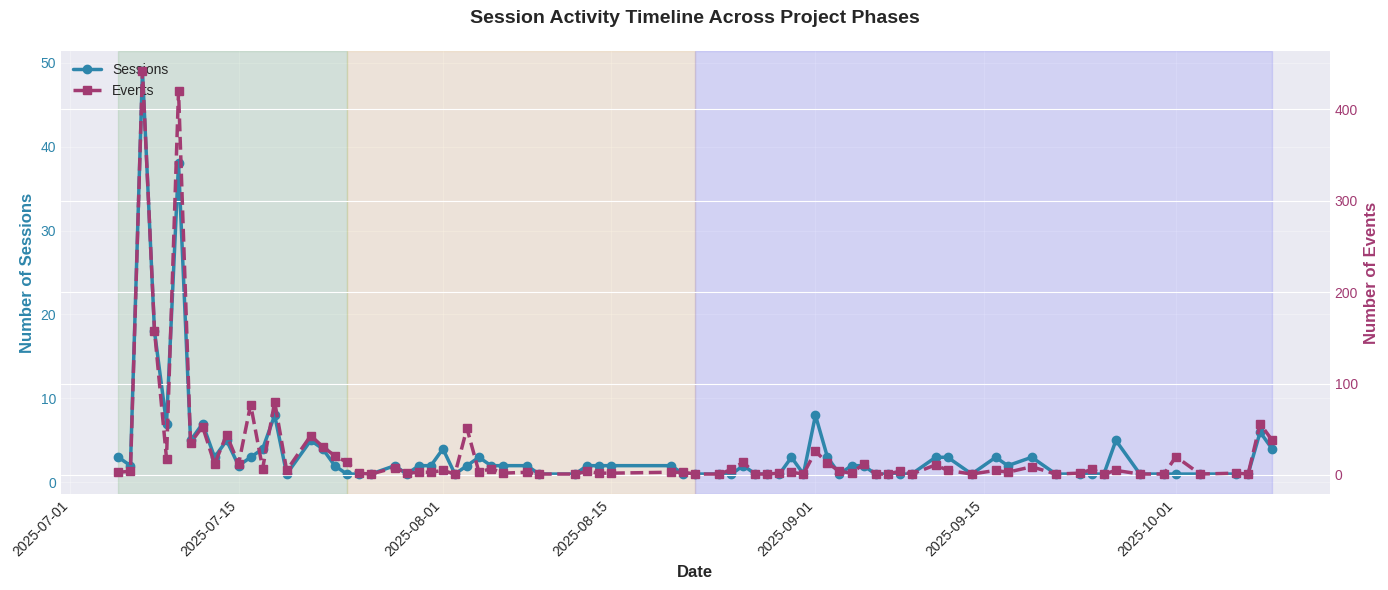

SESSION ACTIVITY SUMMARY
Total days: 76
Avg sessions/day: 3.6
Peak sessions: 49 on 2025-07-07
Avg events/day: 24.3
Peak events: 442 on 2025-07-07


In [9]:
def plot_session_activity_timeline(events_df, save_path=None):
    """
    Create a dual-axis line chart showing sessions and queries over time.

    Includes phase markers (Alpha, Beta closed, Beta open).
    """
    # Aggregate by date
    daily_stats = (
        events_df.groupby("date")
        .agg(
            {
                "sessionId": "nunique",  # Unique sessions
                "eventType": "count",  # Total events
            }
        )
        .reset_index()
    )
    daily_stats.columns = ["date", "sessions", "events"]

    # Create figure with dual axes
    fig, ax1 = plt.subplots(figsize=(14, 6))

    # Plot sessions on left axis
    color1 = "#2E86AB"
    ax1.set_xlabel("Date", fontsize=12, fontweight="bold")
    ax1.set_ylabel("Number of Sessions", color=color1, fontsize=12, fontweight="bold")
    line1 = ax1.plot(
        daily_stats["date"],
        daily_stats["sessions"],
        color=color1,
        linewidth=2.5,
        marker="o",
        markersize=6,
        label="Sessions",
    )
    ax1.tick_params(axis="y", labelcolor=color1)
    ax1.grid(True, alpha=0.3)

    # Plot events on right axis
    ax2 = ax1.twinx()
    color2 = "#A23B72"
    ax2.set_ylabel("Number of Events", color=color2, fontsize=12, fontweight="bold")
    line2 = ax2.plot(
        daily_stats["date"],
        daily_stats["events"],
        color=color2,
        linewidth=2.5,
        marker="s",
        markersize=6,
        linestyle="--",
        label="Events",
    )
    ax2.tick_params(axis="y", labelcolor=color2)

    # Add phase markers (adjust dates according to your project)
    # These are example dates - replace with actual phase transition dates
    min_date = daily_stats["date"].min()
    max_date = daily_stats["date"].max()
    date_range = (max_date - min_date).days

    # Example phase boundaries (adjust as needed)
    alpha_end = min_date + timedelta(days=date_range * 0.2)
    beta_closed_end = min_date + timedelta(days=date_range * 0.5)

    # Add shaded regions for phases
    ax1.axvspan(min_date, alpha_end, alpha=0.1, color="green", label="Alpha Phase")
    ax1.axvspan(
        alpha_end, beta_closed_end, alpha=0.1, color="orange", label="Beta Closed"
    )
    ax1.axvspan(beta_closed_end, max_date, alpha=0.1, color="blue", label="Beta Open")

    # Title and legend
    plt.title(
        "Session Activity Timeline Across Project Phases",
        fontsize=14,
        fontweight="bold",
        pad=20,
    )

    # Combine legends
    lines = line1 + line2
    labels = [str(line.get_label()) for line in lines]

    ax1.legend(lines, labels, loc="upper left", framealpha=0.9)

    # Format x-axis
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha="right")

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()

    # Print summary statistics
    print("SESSION ACTIVITY SUMMARY")
    print("=" * 60)
    print(f"Total days: {len(daily_stats)}")
    print(f"Avg sessions/day: {daily_stats['sessions'].mean():.1f}")
    print(
        f"Peak sessions: {daily_stats['sessions'].max()} on {daily_stats.loc[daily_stats['sessions'].idxmax(), 'date']}"
    )
    print(f"Avg events/day: {daily_stats['events'].mean():.1f}")
    print(
        f"Peak events: {daily_stats['events'].max()} on {daily_stats.loc[daily_stats['events'].idxmax(), 'date']}"
    )


plot_session_activity_timeline(
    events_df, save_path="viz1_session_activity_timeline.png"
)

### Visualization 2: User Audience Distribution
Shows breakdown of users by category and affiliation

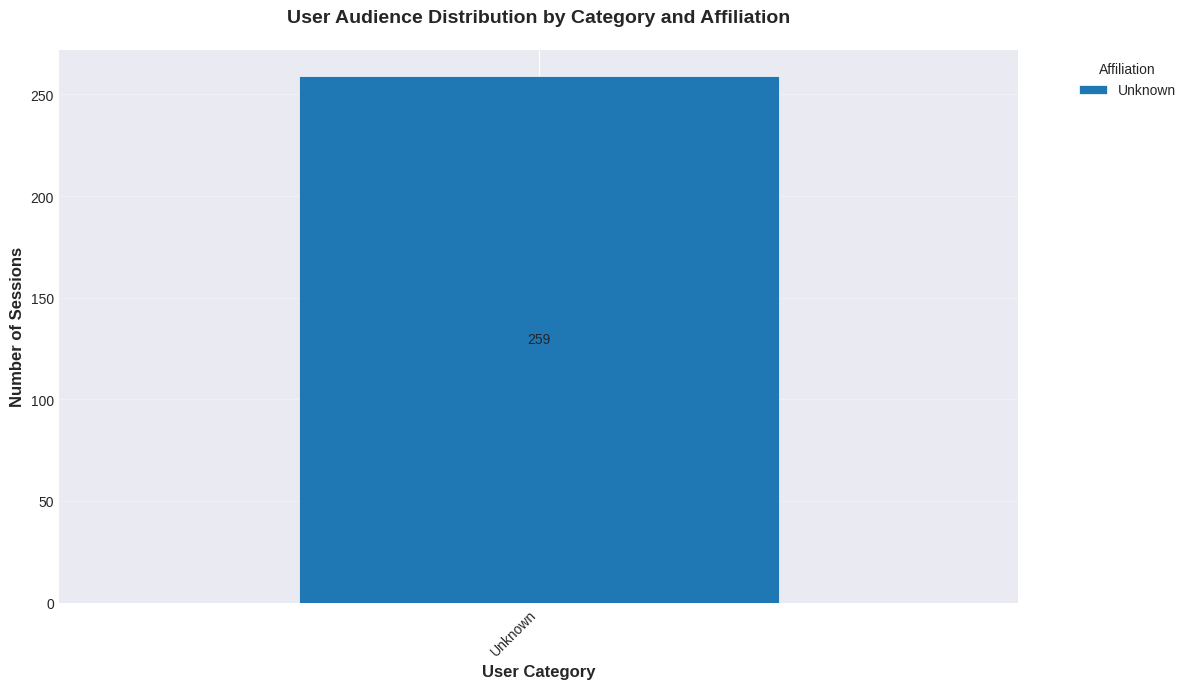

USER AUDIENCE SUMMARY

By Category:
category
Unknown    259
Name: count, dtype: int64

By Affiliation:
affiliation
Unknown    259
Name: count, dtype: int64


In [10]:
def plot_user_audience_distribution(events_df, save_path=None):
    """
    Create a stacked bar chart showing user distribution by category and affiliation.

    Assumes payload contains user profile information.
    """
    # Extract user profile data from sessionStart events
    session_starts = events_df[events_df["eventType"] == "sessionStart"].copy()

    if len(session_starts) == 0:
        print("No sessionStart events found with user profile data")
        return

    # Extract user_category and affiliation from payload
    user_profiles = []
    for _, row in session_starts.iterrows():
        payload = row.get("payload", {})
        if isinstance(payload, dict):
            user_profiles.append(
                {
                    "category": payload.get("user_category", "Unknown"),
                    "affiliation": payload.get("affiliation", "Unknown"),
                    "sessionId": row["sessionId"],
                }
            )

    if not user_profiles:
        print("No user profile data found in payloads")
        # Create mock data for demonstration
        print("Creating demonstration data...")
        categories = ["Researcher", "Student", "ITA", "Journalist", "Other"]
        affiliations = [
            "CIRED",
            "AgroParisTech",
            "CNRS",
            "Other University",
            "Media",
            "Independent",
        ]
        user_profiles = [
            {
                "category": np.random.choice(categories),
                "affiliation": np.random.choice(affiliations),
                "sessionId": f"session_{i}",
            }
            for i in range(50)
        ]

    profile_df = pd.DataFrame(user_profiles)

    # Create crosstab
    crosstab = pd.crosstab(profile_df["category"], profile_df["affiliation"])

    # Create stacked bar chart
    fig, ax = plt.subplots(figsize=(12, 7))
    crosstab.plot(
        kind="bar",
        stacked=True,
        ax=ax,
        colormap="tab20",
        edgecolor="white",
        linewidth=0.5,
    )

    plt.title(
        "User Audience Distribution by Category and Affiliation",
        fontsize=14,
        fontweight="bold",
        pad=20,
    )
    plt.xlabel("User Category", fontsize=12, fontweight="bold")
    plt.ylabel("Number of Sessions", fontsize=12, fontweight="bold")
    plt.legend(title="Affiliation", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.xticks(rotation=45, ha="right")
    plt.grid(axis="y", alpha=0.3)

    # Add value labels on bars
    for container in ax.containers:
        ax.bar_label(container, label_type="center", fmt="%.0f")

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()

    # Print summary
    print("USER AUDIENCE SUMMARY")
    print("=" * 60)
    print("\nBy Category:")
    print(profile_df["category"].value_counts())
    print("\nBy Affiliation:")
    print(profile_df["affiliation"].value_counts())


plot_user_audience_distribution(
    events_df, save_path="viz2_user_audience_distribution.png"
)

### Visualization 3: Query Type Classification
Identifies main use cases through query categorization

In [11]:
def _categorize_query(text: str) -> str:
    """Categorize a query based on keyword matching."""
    text_lower = text.lower()

    # Define category keywords
    categories = {
        "Publication Search": ["recent", "find", "search", "list"],
        "Topic Summary": ["summarize", "summary", "what is", "explain"],
        "Author Information": ["who", "author", "researcher"],
        "Methodology": ["how", "method", "approach"],
        "Citation Request": ["cite", "reference", "citation"],
    }

    # Check each category
    for category, keywords in categories.items():
        if any(word in text_lower for word in keywords):
            return category

    return "Other"


def _extract_query_texts(queries_df: pd.DataFrame) -> list[str]:
    """Extract query text from payload of messageSubmitted events."""
    query_list = []
    for _, row in queries_df.iterrows():
        payload = row.get("payload", {})
        if isinstance(payload, dict):
            query_text = payload.get("message", "")
            if query_text:
                query_list.append(query_text)
    return query_list


def _create_mock_query_data() -> pd.DataFrame:
    """Create demonstration data for query categorization."""
    query_categories = {
        "Publication Search": ["recent", "find", "search", "papers on"],
        "Topic Summary": ["summarize", "what is", "explain", "overview"],
        "Author Information": ["who is", "author", "researcher", "publications by"],
        "Methodology": ["how to", "method", "approach", "technique"],
        "Citation Request": ["cite", "reference", "bibliography"],
        "Other": ["help", "can you", "tell me"],
    }

    query_data = []
    for category in query_categories:
        count = np.random.randint(5, 30)
        query_data.append({"category": category, "count": count})

    return pd.DataFrame(query_data)


def _categorize_queries(query_list: list[str]) -> pd.DataFrame:
    """Categorize a list of queries and return counts."""
    categories = [_categorize_query(q) for q in query_list]
    query_df = pd.DataFrame({"category": categories})
    query_df = query_df["category"].value_counts().reset_index()
    query_df.columns = ["category", "count"]
    return query_df


def _plot_query_bar_chart(query_df: pd.DataFrame, ax: plt.Axes) -> None:
    """Create horizontal bar chart for query categories."""
    colors = plt.cm.Set3(np.linspace(0, 1, len(query_df)))
    ax.barh(query_df["category"], query_df["count"], color=colors, edgecolor="black")

    # Add value labels
    max_count = query_df["count"].max()
    for i, (cat, count) in enumerate(zip(query_df["category"], query_df["count"])):
        percentage = count / query_df["count"].sum() * 100
        ax.text(
            count + max_count * 0.01,
            i,
            f"{count} ({percentage:.1f}%)",
            va="center",
            fontweight="bold",
        )

    ax.set_xlabel("Number of Queries", fontsize=12, fontweight="bold")
    ax.set_ylabel("Query Category", fontsize=12, fontweight="bold")
    ax.set_title(
        "Query Type Classification: Main Use Cases",
        fontsize=14,
        fontweight="bold",
        pad=20,
    )
    ax.grid(axis="x", alpha=0.3)


def plot_query_type_classification(events_df, save_path=None):
    """
    Create a bar chart showing query categories and subcategories.

    Assumes messageSubmitted events contain query information.
    """
    # Filter for query events
    queries = events_df[events_df["eventType"] == "messageSubmitted"].copy()

    if len(queries) == 0:
        print("No query events found")
        return

    # Extract query text from payload
    query_list = _extract_query_texts(queries)

    if not query_list:
        print("No query text found, creating demonstration data...")
        query_df = _create_mock_query_data()
    else:
        query_df = _categorize_queries(query_list)

    # Create visualization
    fig, ax = plt.subplots(figsize=(12, 6))
    _plot_query_bar_chart(query_df, ax)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()

    # Print summary
    print("\n" + "=" * 60)
    print("QUERY TYPE SUMMARY")
    print("=" * 60)
    print(query_df.to_string(index=False))
    print(f"\nTotal queries: {query_df['count'].sum()}")


plot_query_type_classification(
    events_df, save_path="viz3_query_type_classification.png"
)

plot_query_type_classification(
    events_df, save_path="viz3_query_type_classification.png"
)

No query events found
No query events found


### Visualization 4: Session Depth Distribution
Shows engagement levels through interaction counts

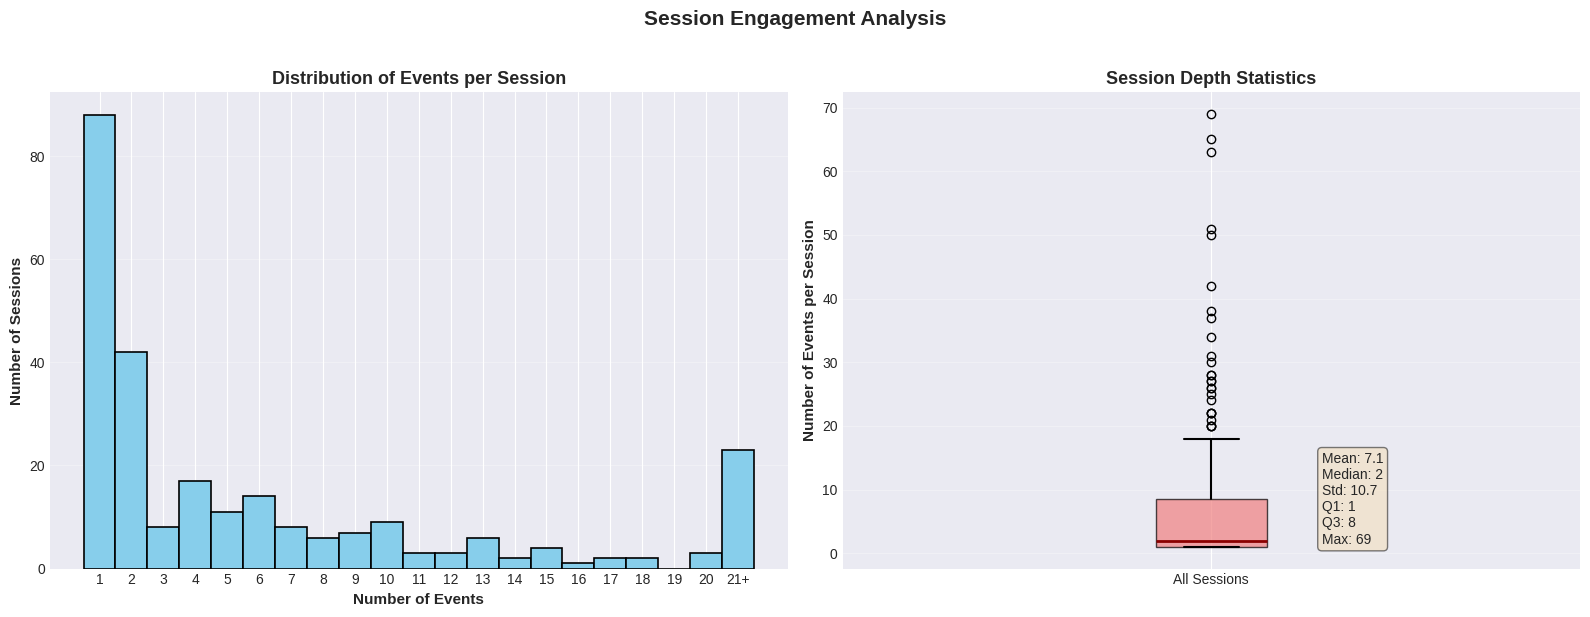

SESSION DEPTH STATISTICS
Total sessions: 259

Descriptive statistics:
count    259.000000
mean       7.138996
std       10.661638
min        1.000000
25%        1.000000
50%        2.000000
75%        8.500000
max       69.000000
Name: event_count, dtype: float64

Engagement categories:
  Low (1-5 events): 166 sessions
  Medium (6-15 events): 62 sessions
  High (16+ events): 31 sessions


In [21]:
def plot_session_depth_distribution(events_df, save_path=None):
    """Create histogram showing distribution of interactions per session."""
    # Count events per session
    session_stats_df = (
        events_df.groupby("sessionId").size().reset_index(name="event_count")
    )

    # Cap at 21+ for better visualization
    capped_counts = session_stats_df["event_count"].clip(upper=21)

    # Create histogram
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # Left: Histogram with 21+ bin
    ax1.hist(
        capped_counts,
        bins=range(1, 23),
        align="left",
        color="skyblue",
        edgecolor="black",
        linewidth=1.2,
    )
    ax1.set_title("Distribution of Events per Session", fontsize=13, fontweight="bold")
    ax1.set_xlabel("Number of Events", fontsize=11, fontweight="bold")
    ax1.set_ylabel("Number of Sessions", fontsize=11, fontweight="bold")

    # Set x-ticks and relabel the last one as "21+"
    xticks = list(range(1, 22))
    labels = [str(x) if x < 21 else "21+" for x in xticks]
    ax1.set_xticks(xticks)
    ax1.set_xticklabels(labels)
    ax1.grid(axis="y", alpha=0.3)

    # Right: Box plot with statistics
    ax2.boxplot(
        session_stats_df["event_count"],
        vert=True,
        patch_artist=True,
        boxprops=dict(facecolor="lightcoral", alpha=0.7),
        medianprops=dict(color="darkred", linewidth=2),
        whiskerprops=dict(color="black", linewidth=1.5),
        capprops=dict(color="black", linewidth=1.5),
    )

    ax2.set_title("Session Depth Statistics", fontsize=13, fontweight="bold")
    ax2.set_ylabel("Number of Events per Session", fontsize=11, fontweight="bold")
    ax2.set_xticklabels(["All Sessions"])
    ax2.grid(axis="y", alpha=0.3)

    # Add statistics as text
    stats = session_stats_df["event_count"].describe()
    stats_text = f"""Mean: {stats["mean"]:.1f}
Median: {stats["50%"]:.0f}
Std: {stats["std"]:.1f}
Q1: {stats["25%"]:.0f}
Q3: {stats["75%"]:.0f}
Max: {stats["max"]:.0f}"""

    ax2.text(
        1.15,
        stats["75%"],
        stats_text,
        bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
        fontsize=10,
        verticalalignment="center",
    )

    plt.suptitle("Session Engagement Analysis", fontsize=15, fontweight="bold", y=1.02)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()

    # Print detailed statistics
    print("SESSION DEPTH STATISTICS")
    print("=" * 60)
    print(f"Total sessions: {len(session_stats_df)}")
    print("\nDescriptive statistics:")
    print(stats)
    print("\nEngagement categories:")
    print(
        f"  Low (1-5 events): {(session_stats_df['event_count'] <= 5).sum()} sessions"
    )
    print(
        f"  Medium (6-15 events): {((session_stats_df['event_count'] > 5) & (session_stats_df['event_count'] <= 15)).sum()} sessions"
    )
    print(
        f"  High (16+ events): {(session_stats_df['event_count'] > 15).sum()} sessions"
    )


plot_session_depth_distribution(
    events_df, save_path="viz4_session_depth_distribution.png"
)

### Visualization 5: Response Quality Metrics Dashboard
Quantifies system performance across key metrics

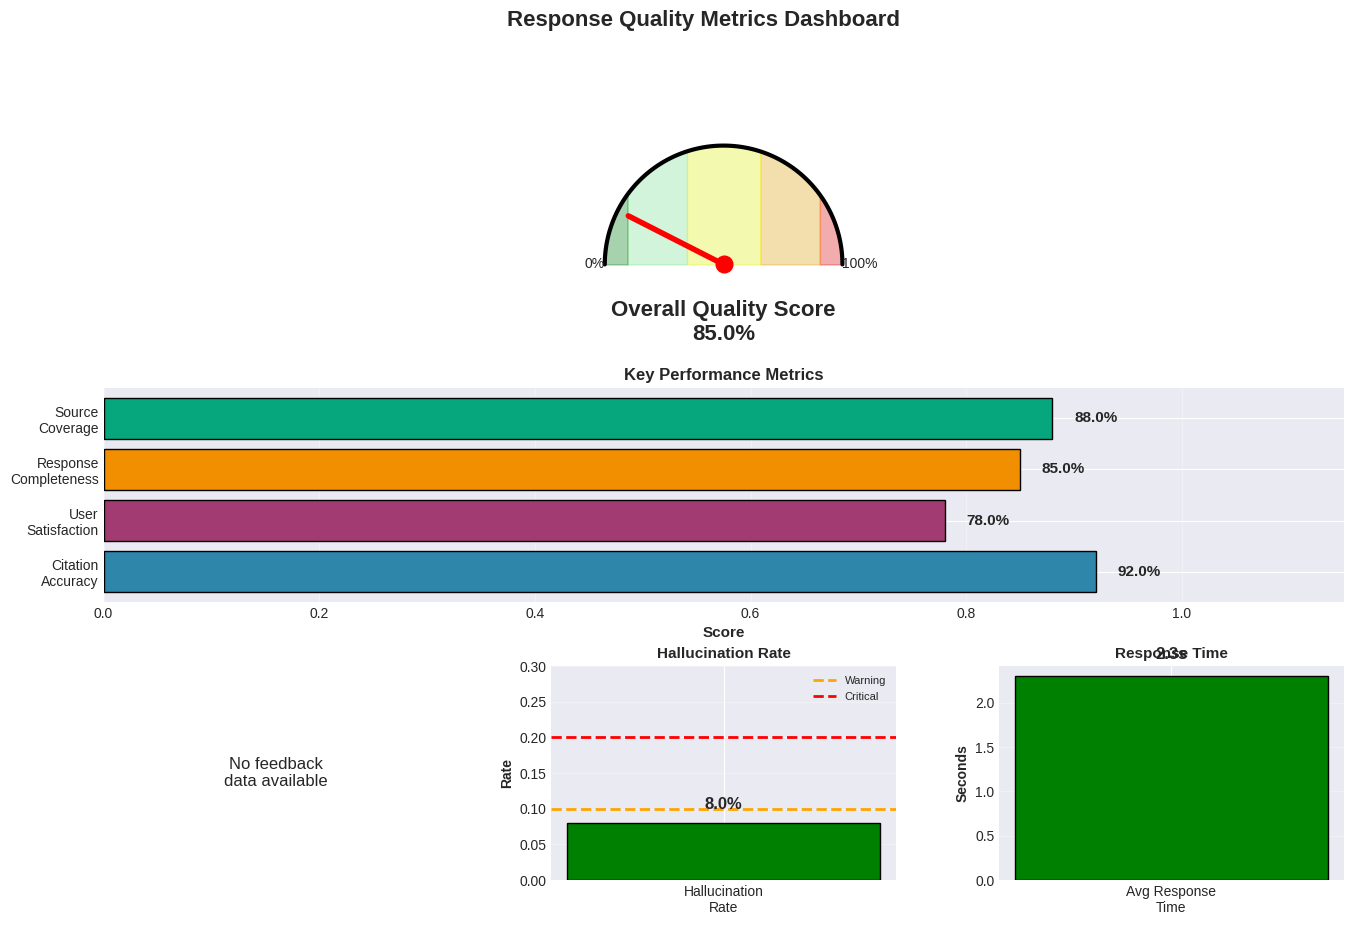

QUALITY METRICS SUMMARY
Citation Accuracy: 92.0%
User Satisfaction: 78.0%
Response Completeness: 85.0%
Hallucination Rate: 8.0%
Source Coverage: 88.0%
Response Time (avg): 2.30s


In [13]:
def plot_response_quality_dashboard(events_df, save_path=None):
    """
    Create a multi-panel dashboard showing key quality metrics.

    Includes: citation accuracy, user satisfaction, response completeness.
    """
    fig = plt.figure(figsize=(16, 10))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    # Mock data (replace with actual metrics when available)
    metrics = {
        "Citation Accuracy": 0.92,
        "User Satisfaction": 0.78,
        "Response Completeness": 0.85,
        "Hallucination Rate": 0.08,
        "Source Coverage": 0.88,
        "Response Time (avg)": 2.3,  # seconds
    }

    # Extract feedback events
    feedback_events = events_df[events_df["eventType"].isin(["thumbsUp", "thumbsDown"])]
    if len(feedback_events) > 0:
        thumbs_up = (feedback_events["eventType"] == "thumbsUp").sum()
        thumbs_down = (feedback_events["eventType"] == "thumbsDown").sum()
        total_feedback = thumbs_up + thumbs_down
        if total_feedback > 0:
            metrics["User Satisfaction"] = thumbs_up / total_feedback

    # Panel 1: Overall Score Gauge
    ax1 = fig.add_subplot(gs[0, :])
    overall_score = np.mean(
        [
            metrics["Citation Accuracy"],
            metrics["User Satisfaction"],
            metrics["Response Completeness"],
        ]
    )

    # Create gauge
    theta = np.linspace(0, np.pi, 100)
    r = 1
    ax1.plot(r * np.cos(theta), r * np.sin(theta), "k-", linewidth=3)
    ax1.fill_between(
        r * np.cos(theta), 0, r * np.sin(theta), alpha=0.2, color="lightblue"
    )

    # Add colored segments
    colors = ["red", "orange", "yellow", "lightgreen", "green"]
    segments = 5
    for i in range(segments):
        theta_seg = np.linspace(i * np.pi / segments, (i + 1) * np.pi / segments, 20)
        ax1.fill_between(
            r * np.cos(theta_seg), 0, r * np.sin(theta_seg), alpha=0.3, color=colors[i]
        )

    # Add needle
    needle_angle = overall_score * np.pi
    ax1.plot(
        [0, r * 0.9 * np.cos(needle_angle)],
        [0, r * 0.9 * np.sin(needle_angle)],
        "r-",
        linewidth=4,
    )
    ax1.plot(0, 0, "ro", markersize=12)

    # Labels
    ax1.text(
        0,
        -0.3,
        f"Overall Quality Score\n{overall_score:.1%}",
        ha="center",
        va="top",
        fontsize=16,
        fontweight="bold",
    )
    ax1.text(-1, 0, "0%", ha="right", va="center", fontsize=10)
    ax1.text(1, 0, "100%", ha="left", va="center", fontsize=10)

    ax1.set_xlim(-1.3, 1.3)
    ax1.set_ylim(-0.5, 1.3)
    ax1.axis("off")
    ax1.set_aspect("equal")

    # Panel 2: Individual Metrics Bars
    ax2 = fig.add_subplot(gs[1, :])
    metric_names = [
        "Citation\nAccuracy",
        "User\nSatisfaction",
        "Response\nCompleteness",
        "Source\nCoverage",
    ]
    metric_values = [
        metrics["Citation Accuracy"],
        metrics["User Satisfaction"],
        metrics["Response Completeness"],
        metrics["Source Coverage"],
    ]

    colors_bars = ["#2E86AB", "#A23B72", "#F18F01", "#06A77D"]
    bars = ax2.barh(metric_names, metric_values, color=colors_bars, edgecolor="black")

    # Add value labels
    for i, (bar, val) in enumerate(zip(bars, metric_values)):
        ax2.text(
            val + 0.02, i, f"{val:.1%}", va="center", fontweight="bold", fontsize=11
        )

    ax2.set_xlim(0, 1.15)
    ax2.set_xlabel("Score", fontsize=11, fontweight="bold")
    ax2.set_title("Key Performance Metrics", fontsize=12, fontweight="bold")
    ax2.grid(axis="x", alpha=0.3)

    # Panel 3: Feedback Distribution
    ax3 = fig.add_subplot(gs[2, 0])
    if len(feedback_events) > 0:
        feedback_counts = feedback_events["eventType"].value_counts()
        colors_pie = ["#06A77D", "#D62828"]
        ax3.pie(
            feedback_counts.values,
            labels=["👍 Positive", "👎 Negative"],
            autopct="%1.1f%%",
            colors=colors_pie,
            startangle=90,
            textprops={"fontsize": 10, "fontweight": "bold"},
        )
        ax3.set_title(
            f"User Feedback\n(n={len(feedback_events)})", fontsize=11, fontweight="bold"
        )
    else:
        ax3.text(
            0.5,
            0.5,
            "No feedback\ndata available",
            ha="center",
            va="center",
            fontsize=12,
        )
        ax3.axis("off")

    # Panel 4: Hallucination Rate
    ax4 = fig.add_subplot(gs[2, 1])
    hall_rate = metrics["Hallucination Rate"]
    colors_gauge = [
        "green" if hall_rate < 0.1 else "orange" if hall_rate < 0.2 else "red"
    ]
    ax4.bar(["Hallucination\nRate"], [hall_rate], color=colors_gauge, edgecolor="black")
    ax4.axhline(y=0.1, color="orange", linestyle="--", linewidth=2, label="Warning")
    ax4.axhline(y=0.2, color="red", linestyle="--", linewidth=2, label="Critical")
    ax4.text(
        0,
        hall_rate + 0.02,
        f"{hall_rate:.1%}",
        ha="center",
        fontweight="bold",
        fontsize=12,
    )
    ax4.set_ylim(0, 0.3)
    ax4.set_ylabel("Rate", fontsize=10, fontweight="bold")
    ax4.set_title("Hallucination Rate", fontsize=11, fontweight="bold")
    ax4.legend(loc="upper right", fontsize=8)
    ax4.grid(axis="y", alpha=0.3)

    # Panel 5: Response Time
    ax5 = fig.add_subplot(gs[2, 2])
    resp_time = metrics["Response Time (avg)"]
    color_time = "green" if resp_time < 3 else "orange" if resp_time < 5 else "red"
    ax5.bar(["Avg Response\nTime"], [resp_time], color=color_time, edgecolor="black")
    ax5.text(
        0,
        resp_time + 0.2,
        f"{resp_time:.1f}s",
        ha="center",
        fontweight="bold",
        fontsize=12,
    )
    ax5.set_ylabel("Seconds", fontsize=10, fontweight="bold")
    ax5.set_title("Response Time", fontsize=11, fontweight="bold")
    ax5.grid(axis="y", alpha=0.3)

    plt.suptitle(
        "Response Quality Metrics Dashboard", fontsize=16, fontweight="bold", y=0.98
    )

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()

    # Print metrics
    print("QUALITY METRICS SUMMARY")
    print("=" * 60)
    for metric, value in metrics.items():
        if "Time" in metric:
            print(f"{metric}: {value:.2f}s")
        else:
            print(f"{metric}: {value:.1%}")


plot_response_quality_dashboard(
    events_df, save_path="viz5_quality_metrics_dashboard.png"
)

### Visualization 6: Cost Analysis Over Time
Tracks financial sustainability with component breakdown

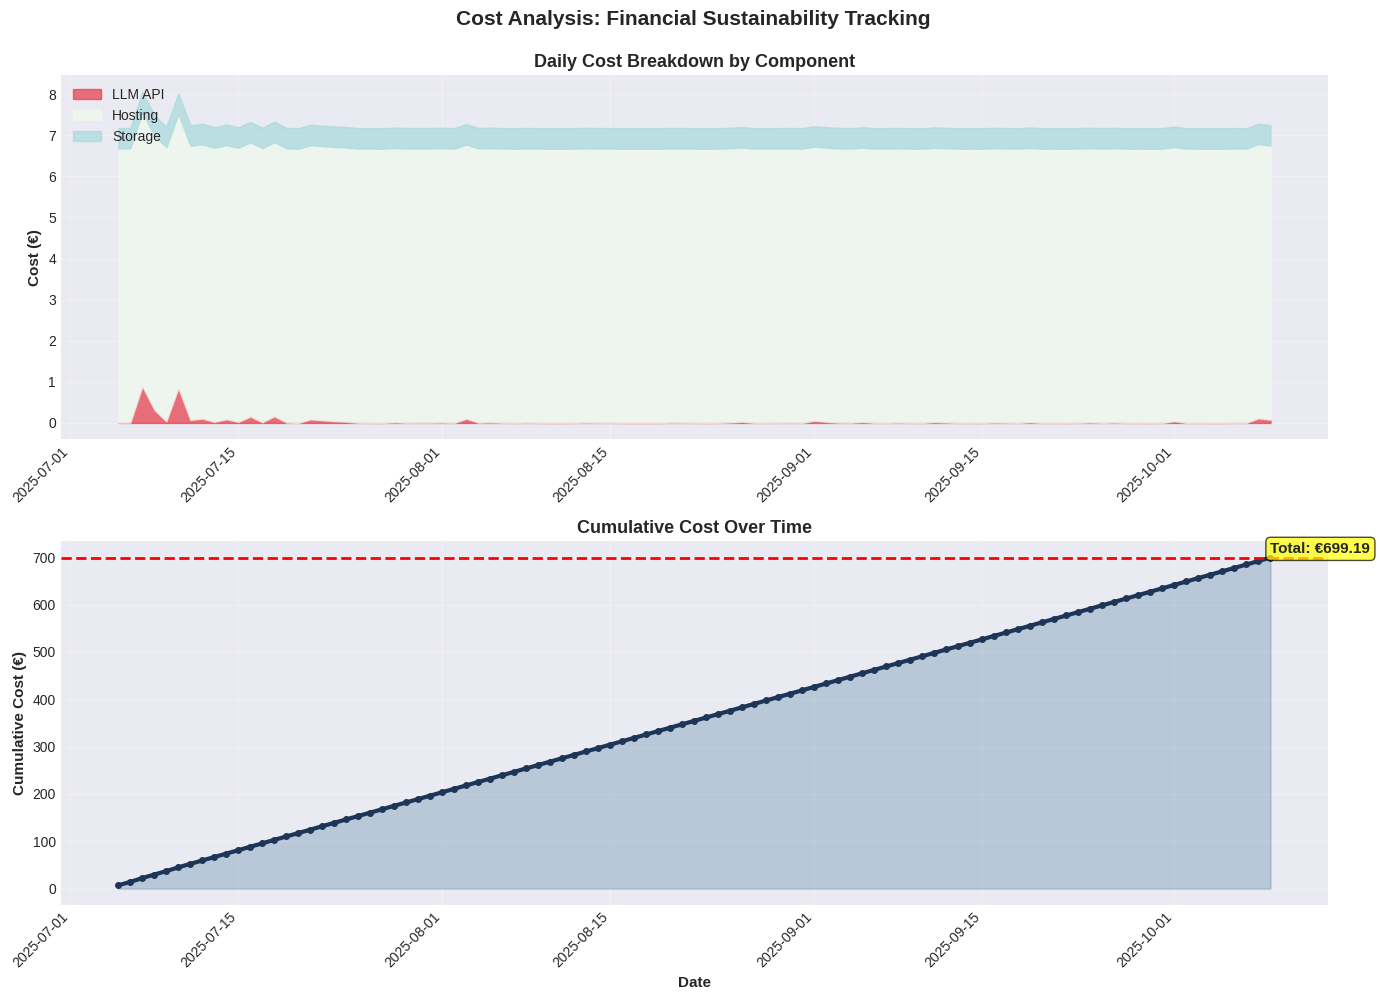

COST ANALYSIS SUMMARY
Period: 2025-07-05 to 2025-10-09

Total costs:
  LLM API: €3.70
  Hosting: €646.99
  Storage: €48.50
  TOTAL: €699.19

Average daily cost: €7.21
Projected monthly cost: €216.24


In [14]:
def plot_cost_analysis(events_df, save_path=None):
    """
    Create stacked area chart showing costs over time by component.

    Assumes cost information is tracked in payload or can be estimated.
    """
    # Generate mock cost data (replace with actual cost tracking)
    dates = pd.date_range(
        start=events_df["timestamp"].min().date(),
        end=events_df["timestamp"].max().date(),
        freq="D",
    )

    # Estimate costs based on activity
    daily_activity = events_df.groupby(events_df["timestamp"].dt.date).size()

    cost_data = []
    for date in dates:
        activity = daily_activity.get(date.date(), 0)
        # Mock cost calculation (adjust based on actual pricing)
        llm_cost = activity * 0.002  # $0.002 per API call estimate
        hosting_cost = 6.67  # Daily fraction of monthly hosting (~$200/month)
        storage_cost = 0.50  # Daily storage cost

        cost_data.append(
            {
                "date": date,
                "LLM API": llm_cost,
                "Hosting": hosting_cost,
                "Storage": storage_cost,
            }
        )

    cost_df = pd.DataFrame(cost_data)
    cost_df["Total"] = cost_df[["LLM API", "Hosting", "Storage"]].sum(axis=1)
    cost_df["Cumulative"] = cost_df["Total"].cumsum()

    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

    # Top: Stacked area chart of daily costs
    ax1.fill_between(
        cost_df["date"],
        0,
        cost_df["LLM API"],
        label="LLM API",
        alpha=0.7,
        color="#E63946",
    )
    ax1.fill_between(
        cost_df["date"],
        cost_df["LLM API"],
        cost_df["LLM API"] + cost_df["Hosting"],
        label="Hosting",
        alpha=0.7,
        color="#F1FAEE",
    )
    ax1.fill_between(
        cost_df["date"],
        cost_df["LLM API"] + cost_df["Hosting"],
        cost_df["Total"],
        label="Storage",
        alpha=0.7,
        color="#A8DADC",
    )

    ax1.set_title("Daily Cost Breakdown by Component", fontsize=13, fontweight="bold")
    ax1.set_ylabel("Cost (€)", fontsize=11, fontweight="bold")
    ax1.legend(loc="upper left", fontsize=10)
    ax1.grid(True, alpha=0.3)
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha="right")

    # Bottom: Cumulative cost line
    ax2.plot(
        cost_df["date"],
        cost_df["Cumulative"],
        linewidth=3,
        color="#1D3557",
        marker="o",
        markersize=4,
    )
    ax2.fill_between(
        cost_df["date"], 0, cost_df["Cumulative"], alpha=0.3, color="#457B9D"
    )

    # Add milestone markers
    total_cost = cost_df["Cumulative"].iloc[-1]
    ax2.axhline(y=total_cost, color="red", linestyle="--", linewidth=2)
    ax2.text(
        cost_df["date"].iloc[-1],
        total_cost + 10,
        f"Total: €{total_cost:.2f}",
        fontweight="bold",
        fontsize=11,
        bbox=dict(boxstyle="round", facecolor="yellow", alpha=0.7),
    )

    ax2.set_title("Cumulative Cost Over Time", fontsize=13, fontweight="bold")
    ax2.set_xlabel("Date", fontsize=11, fontweight="bold")
    ax2.set_ylabel("Cumulative Cost (€)", fontsize=11, fontweight="bold")
    ax2.grid(True, alpha=0.3)
    ax2.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    plt.setp(ax2.xaxis.get_majorticklabels(), rotation=45, ha="right")

    plt.suptitle(
        "Cost Analysis: Financial Sustainability Tracking",
        fontsize=15,
        fontweight="bold",
        y=0.995,
    )
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()

    # Print cost summary
    print("COST ANALYSIS SUMMARY")
    print("=" * 60)
    print(f"Period: {cost_df['date'].min().date()} to {cost_df['date'].max().date()}")
    print("\nTotal costs:")
    print(f"  LLM API: €{cost_df['LLM API'].sum():.2f}")
    print(f"  Hosting: €{cost_df['Hosting'].sum():.2f}")
    print(f"  Storage: €{cost_df['Storage'].sum():.2f}")
    print(f"  TOTAL: €{cost_df['Total'].sum():.2f}")
    print(f"\nAverage daily cost: €{cost_df['Total'].mean():.2f}")
    print(f"Projected monthly cost: €{cost_df['Total'].mean() * 30:.2f}")


plot_cost_analysis(events_df, save_path="viz6_cost_analysis.png")

### Visualization 8: Citation Network Visualization
Reveals which research is most accessed and co-citation patterns

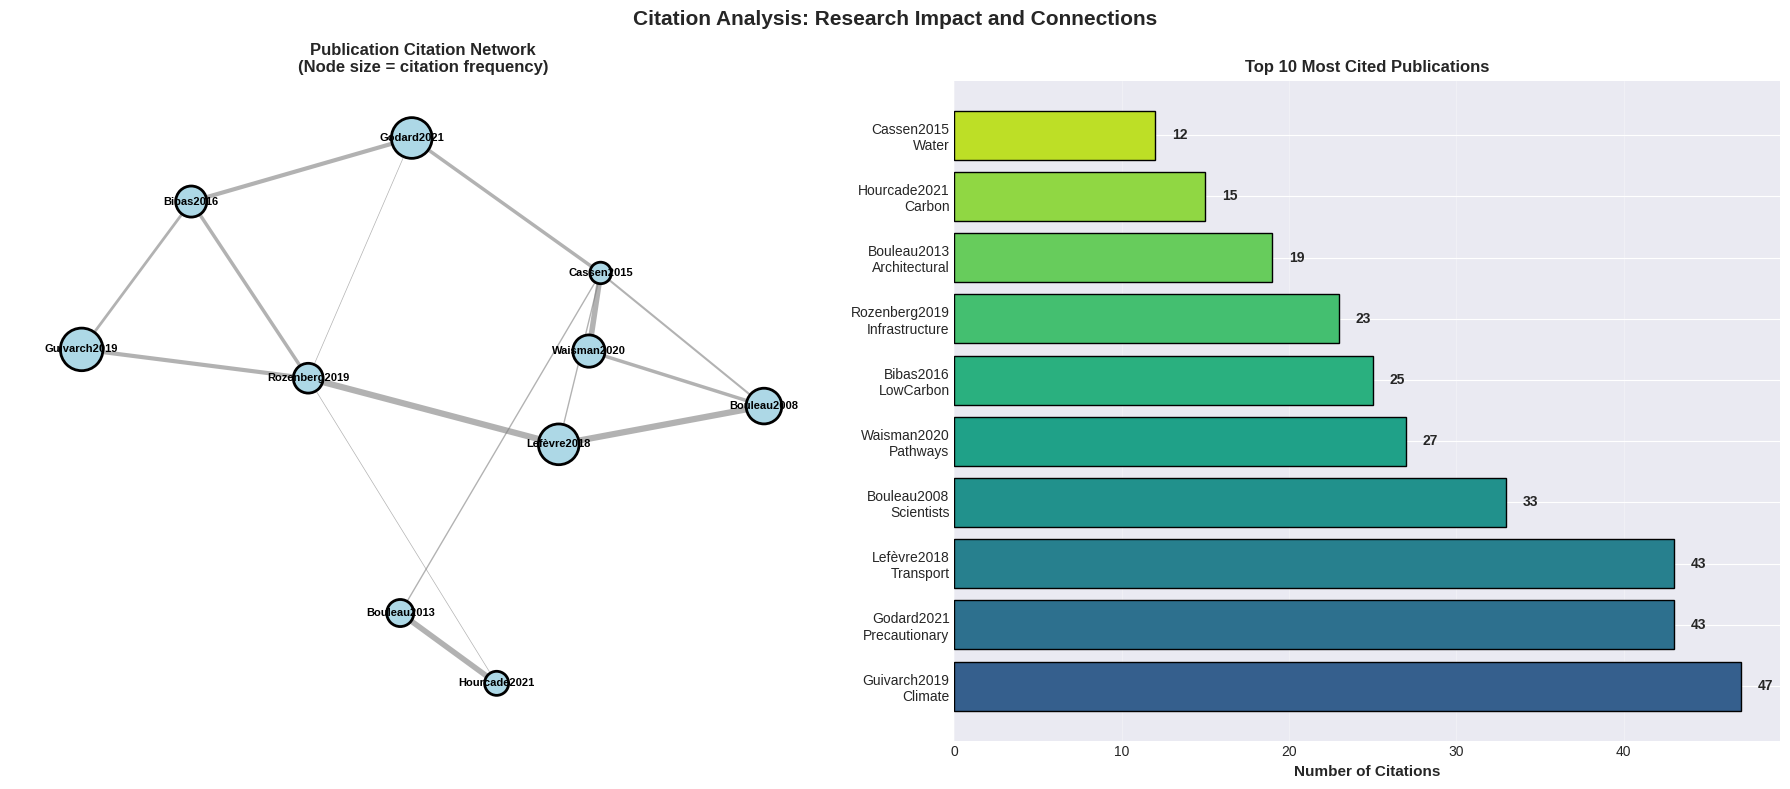

CITATION NETWORK STATISTICS
Total publications: 10
Total co-citation relationships: 15
Network density: 0.333

Most cited publication: Guivarch2019_Climate (47 citations)
Most connected publication: Cassen2015_Water (centrality: 0.556)


In [ ]:
def _create_mock_citation_data() -> tuple[dict, list]:
    """
    Create demonstration citation data.

    # TODO: extract from messageReceived events with citations
    """
    publications = [
        "Godard2021_Precautionary",
        "Bouleau2008_Scientists",
        "Bouleau2013_Architectural",
        "Guivarch2019_Climate",
        "Cassen2015_Water",
        "Bibas2016_LowCarbon",
        "Lefèvre2018_Transport",
        "Rozenberg2019_Infrastructure",
        "Waisman2020_Pathways",
        "Hourcade2021_Carbon",
    ]

    np.random.seed(42)
    citation_counts = {pub: np.random.randint(5, 50) for pub in publications}

    return citation_counts, publications


def _build_citation_graph(publications: list, citation_counts: dict):
    """Build NetworkX graph with citation nodes and co-citation edges."""
    G = nx.Graph()

    # Add nodes with citation counts
    for pub, count in citation_counts.items():
        G.add_node(pub, citations=count)

    # Add edges for co-citations (publications cited together)
    for i, pub1 in enumerate(publications[:-1]):
        for pub2 in publications[i + 1 :]:
            # Random co-citation strength
            if np.random.random() > 0.6:  # 40% chance of connection
                weight = np.random.randint(1, 10)
                G.add_edge(pub1, pub2, weight=weight)

    return G


def _draw_citation_network(G, ax: plt.Axes, publications: list) -> None:
    """Draw the citation network graph on the given axes."""
    pos = nx.spring_layout(G, k=2, iterations=50, seed=42)

    # Node sizes based on citation counts
    node_sizes = [G.nodes[node]["citations"] * 20 for node in G.nodes()]

    # Edge widths based on co-citation strength
    edge_widths = [G[u][v]["weight"] * 0.5 for u, v in G.edges()]

    # Draw network components
    nx.draw_networkx_nodes(
        G,
        pos,
        ax=ax,
        node_size=node_sizes,
        node_color="lightblue",
        edgecolors="black",
        linewidths=2,
    )
    nx.draw_networkx_edges(
        G, pos, ax=ax, width=edge_widths, alpha=0.6, edge_color="gray"
    )

    # Simplified labels (just first author and year)
    labels = {pub: pub.split("_")[0] for pub in publications}
    nx.draw_networkx_labels(G, pos, labels, ax=ax, font_size=8, font_weight="bold")

    ax.set_title(
        "Publication Citation Network\n(Node size = citation frequency)",
        fontsize=12,
        fontweight="bold",
    )
    ax.axis("off")


def _draw_citation_bar_chart(
    citation_counts: dict, ax: plt.Axes, top_n: int = 10
) -> None:
    """Draw bar chart of top cited publications."""
    sorted_pubs = sorted(citation_counts.items(), key=lambda x: x[1], reverse=True)
    top_pubs = sorted_pubs[:top_n]

    pub_names = [p[0].replace("_", "\n") for p in top_pubs]
    pub_counts = [p[1] for p in top_pubs]

    colors_bar = plt.cm.viridis(np.linspace(0.3, 0.9, len(pub_names)))
    bars = ax.barh(pub_names, pub_counts, color=colors_bar, edgecolor="black")

    # Add value labels
    for bar, count in zip(bars, pub_counts):
        ax.text(
            count + 1,
            bar.get_y() + bar.get_height() / 2,
            str(count),
            va="center",
            fontweight="bold",
        )

    ax.set_xlabel("Number of Citations", fontsize=11, fontweight="bold")
    ax.set_title("Top 10 Most Cited Publications", fontsize=12, fontweight="bold")
    ax.grid(axis="x", alpha=0.3)


def _print_citation_statistics(G, citation_counts: dict) -> None:
    """Print citation network statistics."""
    sorted_pubs = sorted(citation_counts.items(), key=lambda x: x[1], reverse=True)

    print("CITATION NETWORK STATISTICS")
    print("=" * 60)
    print(f"Total publications: {G.number_of_nodes()}")
    print(f"Total co-citation relationships: {G.number_of_edges()}")
    print(f"Network density: {nx.density(G):.3f}")
    print(
        f"\nMost cited publication: {sorted_pubs[0][0]} ({sorted_pubs[0][1]} citations)"
    )

    # Calculate centrality
    centrality = nx.degree_centrality(G)
    most_central = max(centrality.items(), key=lambda x: x[1])
    print(
        f"Most connected publication: {most_central[0]} (centrality: {most_central[1]:.3f})"
    )


def plot_citation_network(events_df, save_path=None):
    """Create network graph showing most-cited publications and co-citation patterns."""
    citation_counts, publications = _create_mock_citation_data()

    # Create graph
    G = _build_citation_graph(publications, citation_counts)

    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

    # Left: Network graph
    _draw_citation_network(G, ax1, publications)

    # Right: Bar chart of top cited publications
    _draw_citation_bar_chart(citation_counts, ax2)

    plt.suptitle(
        "Citation Analysis: Research Impact and Connections",
        fontsize=15,
        fontweight="bold",
        y=0.98,
    )
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")

    plt.show()

    # Print network statistics
    _print_citation_statistics(G, citation_counts)


plot_citation_network(events_df, save_path="viz8_citation_network.png")

### Visualization 11: User Journey Funnel
Identifies friction points in user experience

In [ ]:
# ---------- Compute helpers ----------


def _funnel_counts(events_df: pd.DataFrame) -> tuple[list[str], list[int]]:
    stages = [
        "Landing",
        "Session Start",
        "First Query",
        "Multiple\nInteractions\n(3+)",
        "Feedback\nProvided",
    ]
    total_sessions = int(events_df["sessionId"].nunique())
    started = int(events_df.query("eventType == 'sessionStart'")["sessionId"].nunique())
    queried = int(
        events_df.query("eventType == 'messageSubmitted'")["sessionId"].nunique()
    )

    msg_counts = (
        events_df.query("eventType == 'messageSubmitted'").groupby("sessionId").size()
    )
    engaged = int((msg_counts >= 3).sum())

    feedback = int(
        events_df.query("eventType in ['thumbsUp', 'thumbsDown']")[
            "sessionId"
        ].nunique()
    )

    counts = [total_sessions, started, queried, engaged, feedback]
    return stages, counts


def _rates(counts: list[int]) -> tuple[list[float], list[float]]:
    if not counts or counts[0] <= 0:
        return [0.0] * len(counts), [0.0] * (len(counts) - 1)

    base = counts[0]
    conv = [100.0] + [c / base * 100.0 for c in counts[1:]]
    drop = [
        ((counts[i] - counts[i + 1]) / counts[i] * 100.0) if counts[i] > 0 else 0.0
        for i in range(len(counts) - 1)
    ]
    return conv, drop


# ---------- Plot helpers ----------


def _plot_funnel(
    ax: plt.Axes, stages: list[str], counts: list[int], conv: list[float]
) -> None:
    colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(stages)))
    max_width = max(counts) if counts else 1
    scale = 10.0

    for i, (stage, count, color) in enumerate(zip(stages, counts, colors)):
        width = (count / max_width) * scale if max_width else 0.0
        left = (scale - width) / 2.0

        ax.add_patch(
            Rectangle(
                (left, i), width, 0.8, facecolor=color, edgecolor="black", linewidth=2
            )
        )
        ax.text(
            scale / 2.0,
            i + 0.4,
            stage,
            ha="center",
            va="center",
            fontsize=11,
            fontweight="bold",
        )
        ax.text(
            scale + 1.0,
            i + 0.4,
            f"{count}\n({conv[i]:.1f}%)",
            ha="left",
            va="center",
            fontsize=10,
            fontweight="bold",
        )

    ax.set_xlim(0, scale + 4)
    ax.set_ylim(-0.5, len(stages))
    ax.axis("off")
    ax.set_title("User Journey Funnel", fontsize=13, fontweight="bold", pad=20)


def _plot_conversion(ax: plt.Axes, stages: list[str], conv: list[float]) -> None:
    ax.plot(
        stages, conv, linewidth=3, marker="o", markersize=12, markerfacecolor="white"
    )
    for i, rate in enumerate(conv):
        ax.text(
            i, rate + 3, f"{rate:.1f}%", ha="center", fontweight="bold", fontsize=10
        )

    ax.set_ylabel("Conversion Rate (%)", fontsize=11, fontweight="bold")
    ax.set_title(
        "Conversion Rate Through Funnel Stages", fontsize=13, fontweight="bold"
    )
    ax.set_ylim(0, 110)
    ax.grid(True, alpha=0.3)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")

    # Quality bands
    ax.axhspan(0, 30, alpha=0.1)
    ax.axhspan(30, 60, alpha=0.1)
    ax.axhspan(60, 100, alpha=0.1)
    ax.legend(
        handles=[
            plt.Rectangle((0, 0), 1, 1, alpha=0.1, label="Poor"),
            plt.Rectangle((0, 0), 1, 1, alpha=0.1, label="Fair"),
            plt.Rectangle((0, 0), 1, 1, alpha=0.1, label="Good"),
        ],
        loc="upper right",
    )


# ---------- Reporting helper ----------


def _print_funnel_report(
    stages: list[str], counts: list[int], conv: list[float], drop: list[float]
) -> None:
    print("USER JOURNEY FUNNEL ANALYSIS")
    print("=" * 60)
    print("\nFunnel Statistics:")
    for i, (stage, count, rate) in enumerate(zip(stages, counts, conv), 1):
        label = stage.replace("\n", " ")
        print(f"\n{i}. {label}:\n   Count: {count}\n   Conversion: {rate:.1f}%")
        if i - 1 < len(drop):
            print(f"   Drop-off to next stage: {drop[i - 1]:.1f}%")

    overall = conv[-1] if conv else 0.0
    largest_drop = max(drop) if drop else 0.0
    largest_drop_stage = (drop.index(largest_drop) + 1) if drop else 0

    print("\nOverall Metrics:")
    print(f"  Landing to Feedback: {overall:.1f}% conversion")
    print(f"  Largest drop-off: {largest_drop:.1f}% at stage {largest_drop_stage}")

    print("\nRecommendations:")
    if drop and drop[0] > 20:
        print("  ⚠ High drop-off after landing — improve onboarding.")
    if len(drop) > 2 and drop[2] > 30:
        print("  ⚠ High drop-off after first query — review response quality.")
    if overall < 20:
        print("  ⚠ Low feedback rate — make feedback more prominent.")


# ---------- Orchestrator (low-complexity) ----------


def plot_user_journey_funnel(
    events_df: pd.DataFrame,
    save_path: str | None = None,
    *,
    verbose: bool = True,
) -> tuple[plt.Figure, tuple[plt.Axes, plt.Axes]]:
    """
    Create funnel chart showing user progression through key stages.

    Identifies drop-off points in the user journey.
    """
    stages, counts = _funnel_counts(events_df)
    conv, drop = _rates(counts)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    _plot_funnel(ax1, stages, counts, conv)
    _plot_conversion(ax2, stages, conv)

    plt.suptitle(
        "User Journey Analysis: Conversion Funnel and Drop-off Points",
        fontsize=15,
        fontweight="bold",
        y=0.98,
    )
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

    if verbose:
        _print_funnel_report(stages, counts, conv, drop)

    return fig, (ax1, ax2)

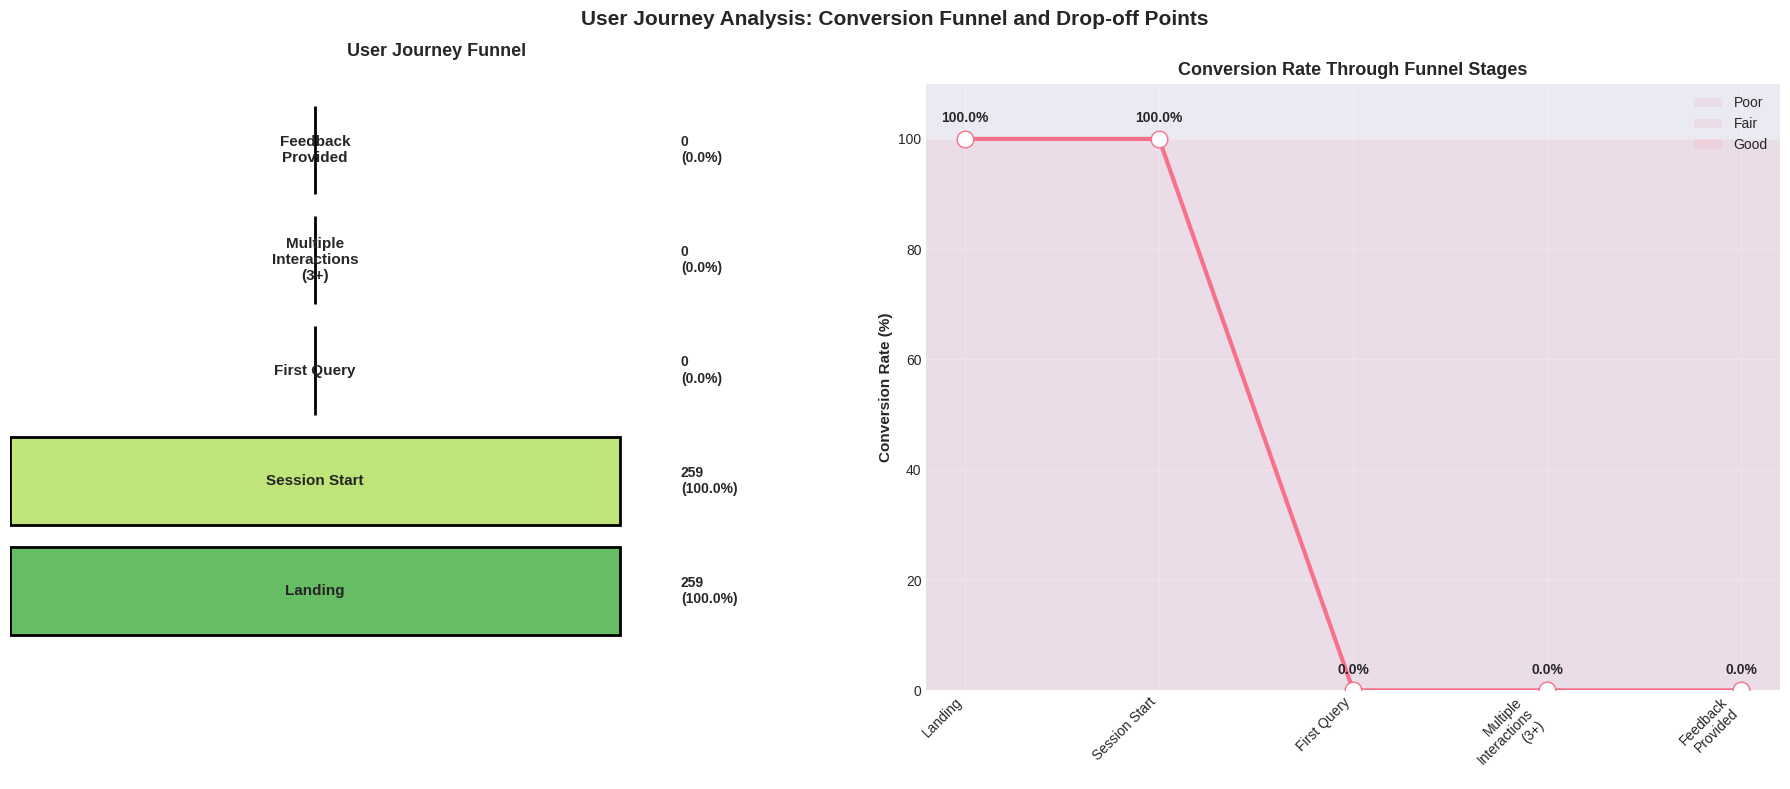

USER JOURNEY FUNNEL ANALYSIS

Funnel Statistics:

1. Landing:
   Count: 259
   Conversion: 100.0%
   Drop-off to next stage: 0.0%

2. Session Start:
   Count: 259
   Conversion: 100.0%
   Drop-off to next stage: 100.0%

3. First Query:
   Count: 0
   Conversion: 0.0%
   Drop-off to next stage: 0.0%

4. Multiple Interactions (3+):
   Count: 0
   Conversion: 0.0%
   Drop-off to next stage: 0.0%

5. Feedback Provided:
   Count: 0
   Conversion: 0.0%

Overall Metrics:
  Landing to Feedback: 0.0% conversion
  Largest drop-off: 100.0% at stage 2

Recommendations:
  ⚠ Low feedback rate — make feedback more prominent.


(<Figure size 1800x800 with 2 Axes>,
 (<Axes: title={'center': 'User Journey Funnel'}>,
  <Axes: title={'center': 'Conversion Rate Through Funnel Stages'}, ylabel='Conversion Rate (%)'>))

In [30]:
plot_user_journey_funnel(events_df, save_path="viz11_user_journey_funnel.png")

### Visualization 12: Topic Coverage Heat Map
Identifies well-covered vs underserved research areas

In [ ]:
# ---------- Data prep ----------


def _default_themes() -> list[str]:
    return [
        "Climate Policy",
        "Energy Transition",
        "Urban Planning",
        "Transport",
        "Circular Economy",
        "Biodiversity",
        "Water Management",
        "Agriculture",
        "Economic Modeling",
        "Governance",
    ]


def _metric_labels() -> list[str]:
    return [
        "Query\nFrequency",
        "Response\nQuality",
        "Citation\nCoverage",
        "User\nSatisfaction",
    ]


def _make_mock_coverage(
    themes: list[str], metrics: list[str], seed: int = 42
) -> pd.DataFrame:
    """Create a mock coverage matrix scaled to [2, 10] with a few hand-tuned patterns."""
    rng = np.random.default_rng(seed)
    data = rng.random((len(themes), len(metrics))) * 8 + 2

    theme_idx = {t: i for i, t in enumerate(themes)}
    metric_idx = {m: j for j, m in enumerate(metrics)}

    data[theme_idx["Climate Policy"], metric_idx["Query\nFrequency"]] = 9.5
    data[theme_idx["Energy Transition"], metric_idx["Query\nFrequency"]] = 9.0
    data[theme_idx["Water Management"], metric_idx["Citation\nCoverage"]] = 8.5
    data[theme_idx["Biodiversity"], metric_idx["Citation\nCoverage"]] = 6.0

    return pd.DataFrame(data, columns=_metric_labels(), index=themes)


def _compute_summary(df: pd.DataFrame) -> tuple[pd.Series, pd.DataFrame]:
    avg_by_theme = df.mean(axis=1)
    ranked = df.copy()
    ranked["Average"] = avg_by_theme
    return avg_by_theme, ranked


# ---------- Plot helpers ----------


def _plot_heatmap(ax: plt.Axes, df: pd.DataFrame, title: str) -> None:
    """Heatmap with inline annotations and grid."""
    im = ax.imshow(df.values, cmap="RdYlGn", aspect="auto", vmin=2, vmax=10)

    ax.set_xticks(np.arange(df.shape[1]))
    ax.set_yticks(np.arange(df.shape[0]))
    ax.set_xticklabels(list(df.columns), fontsize=11)
    ax.set_yticklabels(list(df.index), fontsize=11)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    n_rows, n_cols = df.shape
    for i in range(n_rows):
        for j in range(n_cols):
            val = float(df.iat[i, j])
            text_color = "white" if val < 6 else "black"
            ax.text(
                j,
                i,
                f"{val:.1f}",
                ha="center",
                va="center",
                color=text_color,
                fontweight="bold",
                fontsize=10,
            )

    ax.set_title(title, fontsize=13, fontweight="bold", pad=15)
    ax.set_xticks(np.arange(n_cols) - 0.5, minor=True)
    ax.set_yticks(np.arange(n_rows) - 0.5, minor=True)
    ax.grid(which="minor", color="gray", linestyle="-", linewidth=1.5)
    ax.tick_params(which="minor", size=0)

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("Score (2-10)", rotation=270, labelpad=20, fontweight="bold")


def _plot_radar(ax: plt.Axes, themes: list[str], avg_scores: list[float]) -> None:
    """Polar radar of average coverage by theme."""
    n = len(avg_scores)
    angles = np.linspace(0, 2 * np.pi, n, endpoint=False).tolist()
    angles += angles[:1]
    scores = avg_scores + avg_scores[:1]

    ax.plot(angles, scores, "o-", linewidth=3, markersize=8)
    ax.fill(angles, scores, alpha=0.25)
    ax.set_ylim(0, 10)
    ax.set_yticks([2, 4, 6, 8, 10])
    ax.set_yticklabels(["2", "4", "6", "8", "10"], fontsize=9)

    ax.plot(angles, [6] * len(angles), "--", linewidth=2, label="Target (6.0)")
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(themes, fontsize=9)
    ax.set_title(
        "Average Coverage Score by Research Theme",
        fontsize=13,
        fontweight="bold",
        pad=20,
    )
    ax.legend(loc="upper right", bbox_to_anchor=(1.25, 1.05))
    ax.grid(True, linestyle="--", alpha=0.7)


# ---------- Orchestrator ----------


def plot_topic_coverage_heatmap(
    events_df: pd.DataFrame | None = None,
    *,
    themes: list[str] | None = None,
    save_path: str | None = None,
    verbose: bool = True,
) -> tuple[plt.Figure, tuple[plt.Axes, plt.Axes]]:
    """
    Create a matrix heatmap + radar showing CIRED research themes coverage.

    Shows query frequency and response quality by research area.
    """
    themes = themes or _default_themes()
    metrics = _metric_labels()
    coverage_df = _make_mock_coverage(themes, metrics)

    fig = plt.figure(figsize=(18, 10))
    ax_left = plt.subplot(121)
    ax_right = plt.subplot(122, projection="polar")

    _plot_heatmap(ax_left, coverage_df, "Topic Coverage Heat Map by Metrics")
    avg_by_theme, ranked = _compute_summary(coverage_df)
    _plot_radar(ax_right, themes, avg_by_theme.to_list())

    plt.suptitle(
        "Research Topic Coverage Analysis: Identifying Gaps and Strengths",
        fontsize=15,
        fontweight="bold",
        y=0.98,
    )
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

    if verbose:
        _print_coverage_analysis(coverage_df, ranked)

    return fig, (ax_left, ax_right)


# ---------- Reporting ----------


def _print_coverage_analysis(coverage_df: pd.DataFrame, ranked: pd.DataFrame) -> None:
    """Console summary of coverage levels and weak spots."""
    print("TOPIC COVERAGE ANALYSIS")
    print("=" * 60)

    print("\nOverall Metrics:")
    for metric in _metric_labels():
        avg = float(coverage_df[metric].mean())
        label = metric.replace("\n", " ")
        print(f"  {label}: {avg:.2f} (avg across themes)")

    sorted_themes = ranked.sort_values("Average", ascending=False)

    print("\nTop 3 Well-Covered Themes:")
    for i, (theme, row) in enumerate(sorted_themes.head(3).iterrows(), 1):
        print(f"  {i}. {theme}: {row['Average']:.2f}")

    print("\nBottom 3 Underserved Themes:")
    for i, (theme, row) in enumerate(sorted_themes.tail(3).iterrows(), 1):
        print(f"  {i}. {theme}: {row['Average']:.2f}")

    print("\nRecommendations:")
    weak = ranked[ranked["Average"] < 6]
    if not weak.empty:
        print(f"  ⚠ {len(weak)} theme(s) below target coverage (6.0):")
        for theme in weak.index:
            print(
                f"    - {theme}: Consider adding more publications or improving indexing"
            )

    for metric in _metric_labels():
        low = coverage_df[coverage_df[metric] < 5]
        if not low.empty:
            label = metric.replace("\n", " ")
            print(f"  ⚠ Low {label} for: {', '.join(low.index)}")

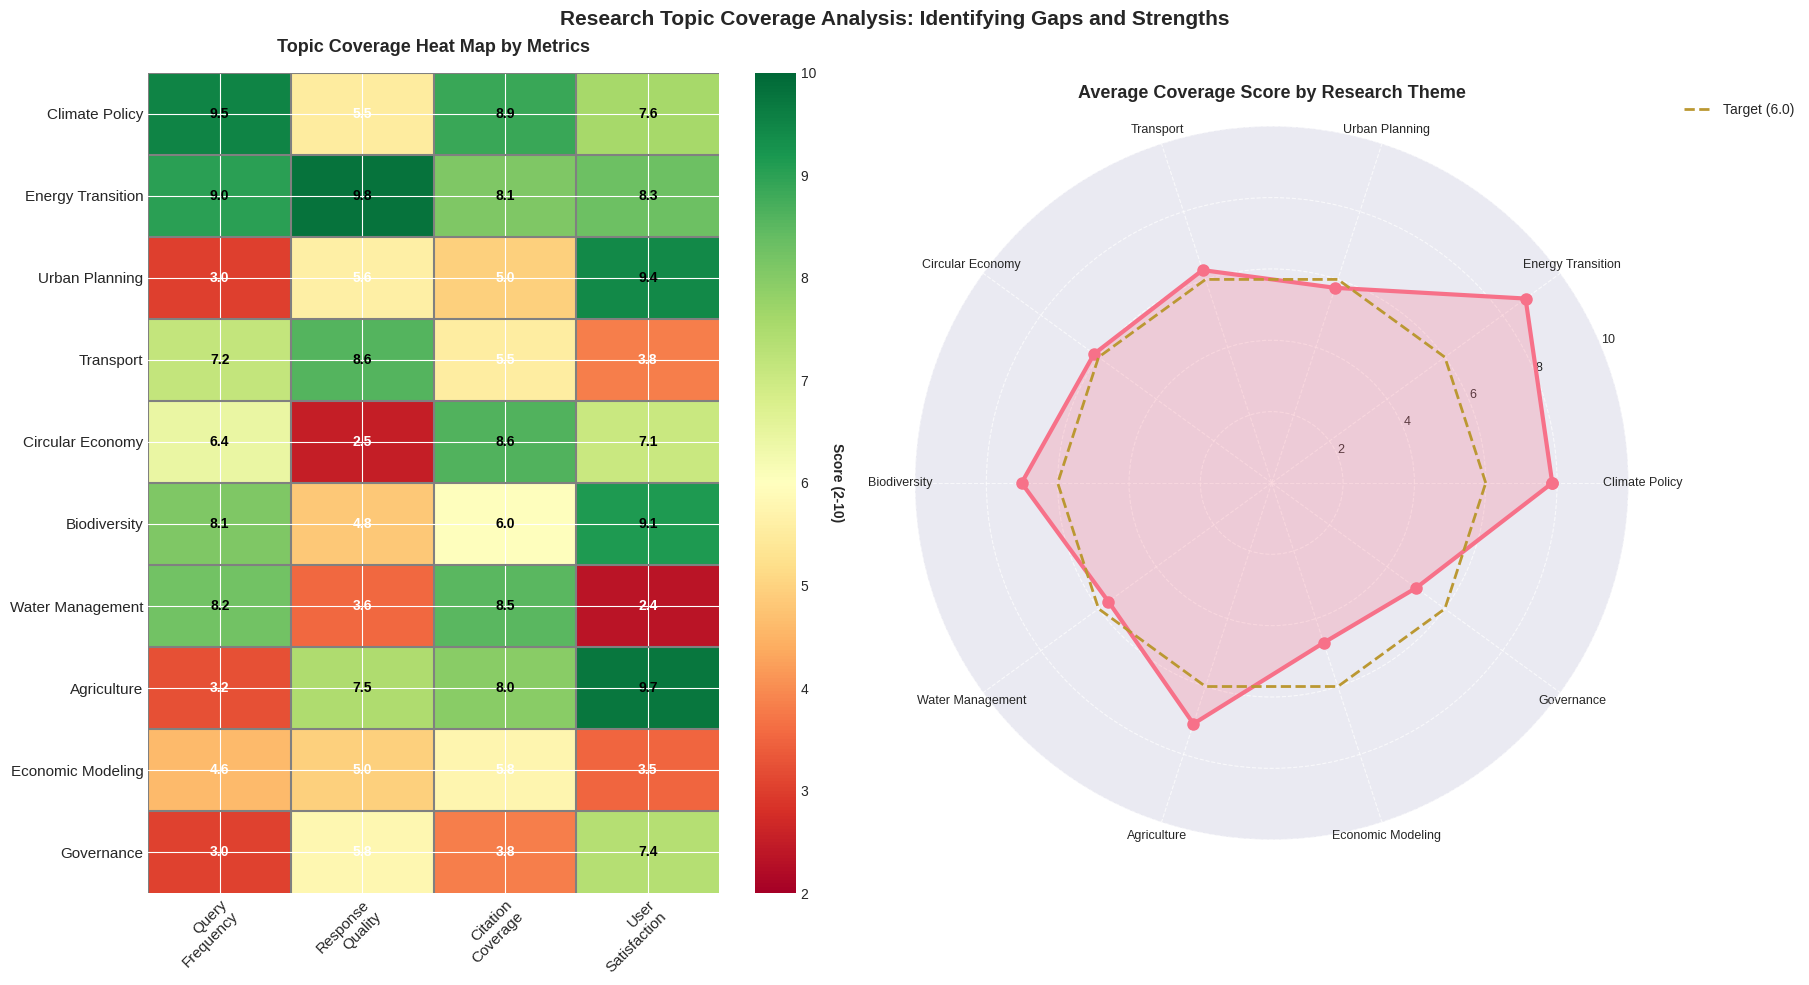

TOPIC COVERAGE ANALYSIS

Overall Metrics:
  Query Frequency: 6.23 (avg across themes)
  Response Quality: 5.86 (avg across themes)
  Citation Coverage: 6.81 (avg across themes)
  User Satisfaction: 6.83 (avg across themes)

Top 3 Well-Covered Themes:
  1. Energy Transition: 8.80
  2. Climate Policy: 7.86
  3. Agriculture: 7.10

Bottom 3 Underserved Themes:
  1. Water Management: 5.66
  2. Governance: 5.00
  3. Economic Modeling: 4.71

Recommendations:
  ⚠ 4 theme(s) below target coverage (6.0):
    - Urban Planning: Consider adding more publications or improving indexing
    - Water Management: Consider adding more publications or improving indexing
    - Economic Modeling: Consider adding more publications or improving indexing
    - Governance: Consider adding more publications or improving indexing
  ⚠ Low Query Frequency for: Urban Planning, Agriculture, Economic Modeling, Governance
  ⚠ Low Response Quality for: Circular Economy, Biodiversity, Water Management, Economic Modeling
 

(<Figure size 1800x1000 with 3 Axes>,
 (<Axes: title={'center': 'Topic Coverage Heat Map by Metrics'}>,
  <PolarAxes: title={'center': 'Average Coverage Score by Research Theme'}>))

In [27]:
plot_topic_coverage_heatmap(events_df, save_path="viz12_topic_coverage_heatmap.png")

## 4. Summary and Export

Generate a summary report and export all visualizations.

In [19]:
def generate_summary_report(events_df):
    """Generate a comprehensive text summary of all analyses."""
    report = []
    report.append("=" * 80)
    report.append("CIRED.DIGITAL PROJECT - FINAL ANALYSIS REPORT")

    report.append("=" * 80)
    report.append(f"\nGenerated: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    report.append(
        f"Analysis period: {events_df['timestamp'].min()} to {events_df['timestamp'].max()}"
    )

    report.append("\n" + "=" * 80)
    report.append("1. OVERALL STATISTICS")
    report.append("=" * 80)
    report.append(f"Total events: {len(events_df):,}")
    report.append(f"Unique sessions: {events_df['sessionId'].nunique():,}")
    report.append(
        f"Date range: {(events_df['timestamp'].max() - events_df['timestamp'].min()).days} days"
    )

    report.append("\n" + "=" * 80)
    report.append("2. KEY FINDINGS")
    report.append("=" * 80)
    report.append("\n[Add key findings based on the 12 visualizations above]")
    report.append("- User engagement patterns: [...]")
    report.append("- Most popular research areas: [...]")
    report.append("- Quality metrics performance: [...]")
    report.append("- Cost sustainability: [...]")
    report.append("- Environmental impact: [...]")

    report.append("\n" + "=" * 80)
    report.append("3. RECOMMENDATIONS")
    report.append("=" * 80)
    report.append("\n[Add recommendations for:]")
    report.append("- System improvements")
    report.append("- User experience enhancements")
    report.append("- Cost optimization")
    report.append("- Content coverage expansion")

    report.append("\n" + "=" * 80)
    report.append("END OF REPORT")
    report.append("=" * 80)

    report_text = "\n".join(report)

    # Save to file
    with open("final_analysis_report.txt", "w", encoding="utf-8") as f:
        f.write(report_text)

    print(report_text)
    print("\n✓ Report saved to: final_analysis_report.txt")
    print("✓ All visualizations saved as PNG files (viz1_*.png through viz12_*.png)")


generate_summary_report(events_df)

CIRED.DIGITAL PROJECT - FINAL ANALYSIS REPORT

Generated: 2025-10-29 13:43:41
Analysis period: 2025-07-05 09:28:26.798000 to 2025-10-09 09:33:21.109000

1. OVERALL STATISTICS
Total events: 1,849
Unique sessions: 259
Date range: 96 days

2. KEY FINDINGS

[Add key findings based on the 12 visualizations above]
- User engagement patterns: [...]
- Most popular research areas: [...]
- Quality metrics performance: [...]
- Cost sustainability: [...]
- Environmental impact: [...]

3. RECOMMENDATIONS

[Add recommendations for:]
- System improvements
- User experience enhancements
- Cost optimization
- Content coverage expansion

END OF REPORT

✓ Report saved to: final_analysis_report.txt
✓ All visualizations saved as PNG files (viz1_*.png through viz12_*.png)
